In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import os
import time

import h5py
import matplotlib as mpl, matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data import Dataset
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms

from datasets import *
from models import *
from solver import Solver

from sklearn.metrics import confusion_matrix, average_precision_score
from sklearn.utils.multiclass import unique_labels

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# def plot_confusion_matrix(y_true, y_pred, classes,
#                           normalize=False,
#                           title=None,
#                           cmap=plt.cm.Blues):
#     """
#     This function prints and plots the confusion matrix.
#     Normalization can be applied by setting `normalize=True`.
#     """
#     if not title:
#         if normalize:
#             title = 'Normalized confusion matrix'
#         else:
#             title = 'Confusion matrix, without normalization'

#     # Compute confusion matrix
#     cm = confusion_matrix(y_true, y_pred)
#     # Only use the labels that appear in the data
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

#     print(cm)

#     fig, ax = plt.subplots()
#     im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
#     ax.figure.colorbar(im, ax=ax)
#     # We want to show all ticks...
#     ax.set(xticks=np.arange(cm.shape[1]),
#            yticks=np.arange(cm.shape[0]),
#            # ... and label them with the respective list entries
#            xticklabels=classes, yticklabels=classes,
#            title=title,
#            ylabel='True label',
#            xlabel='Predicted label')

#     # Rotate the tick labels and set their alignment.
#     plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
#              rotation_mode="anchor")

#     # Loop over data dimensions and create text annotations.
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i in range(cm.shape[0]):
#         for j in range(cm.shape[1]):
#             ax.text(j, i, format(cm[i, j], fmt),
#                     ha="center", va="center",
#                     color="white" if cm[i, j] > thresh else "black")
#     fig.tight_layout()
#     return ax

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                         save=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    if save != None:
        plt.savefig(save)
    return ax

checkpoint_0500.model 0 None micro gaze real 16
Normalized confusion matrix
Accuracy	0.8748
mAP	0.9446

checkpoint_0500.model 1 None micro gaze diff 256
Normalized confusion matrix
Accuracy	0.9161
mAP	0.9713

checkpoint_0500.model 2 None micro gaze real 256
Normalized confusion matrix
Accuracy	0.8548
mAP	0.9174

checkpoint_0500.model 3 None micro gaze diff 16
Normalized confusion matrix
Accuracy	0.9347
mAP	0.9799

checkpoint_0500.model 4 None micro gaze binary 256
Normalized confusion matrix
Accuracy	0.8161
mAP	0.8790

checkpoint_0500.model 5 None micro joy real 256
Normalized confusion matrix
Accuracy	0.8334
mAP	0.8713

checkpoint_0500.model 6 None micro joy diff 16
Normalized confusion matrix
Accuracy	0.9014
mAP	0.9631

checkpoint_0500.model 7 None micro joy diff 256
Normalized confusion matrix
Accuracy	0.8927
mAP	0.9594

checkpoint_0500.model 8 None micro joy real 16
Normalized confusion matrix
Accuracy	0.8461
mAP	0.8644

checkpoint_0500.model 9 None micro joy binary 256
Normalized 

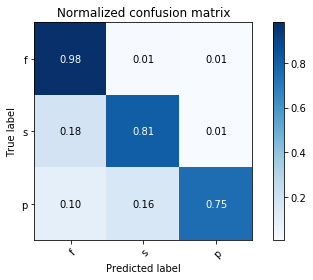

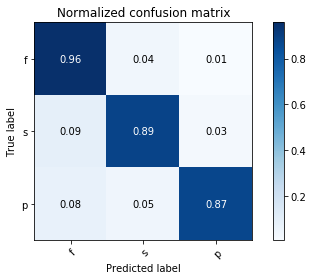

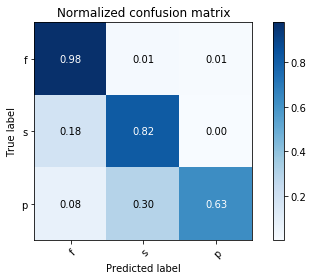

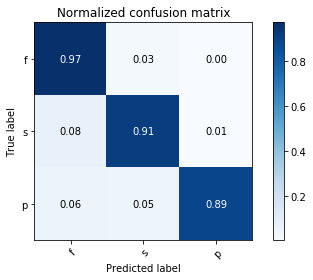

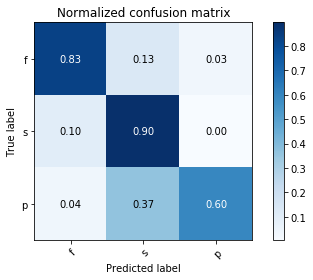

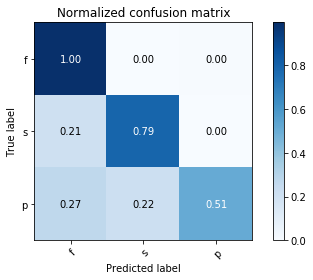

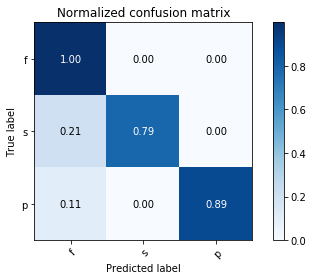

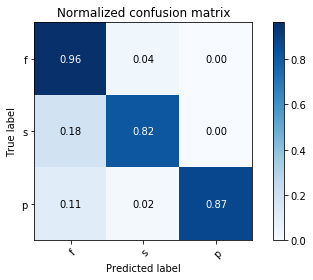

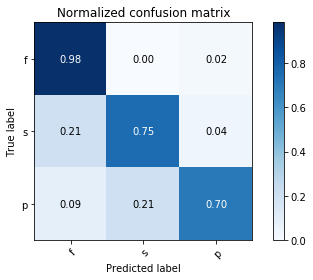

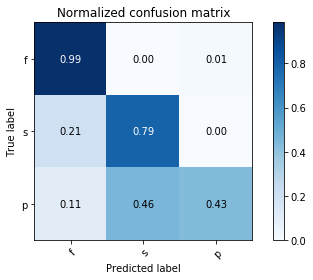

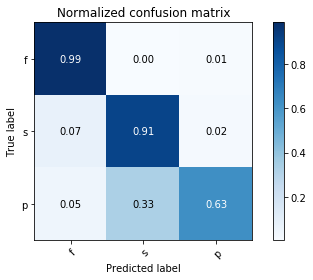

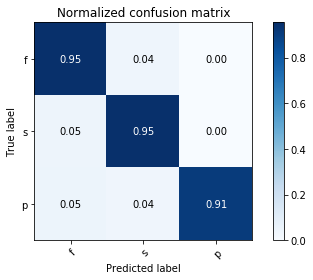

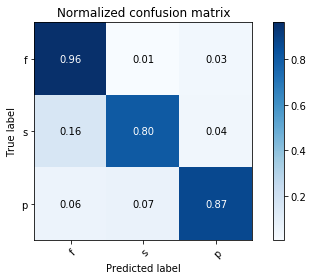

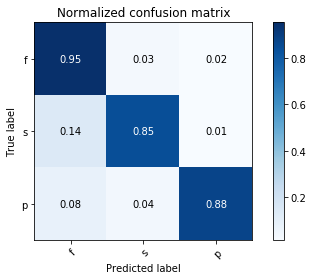

In [10]:
place = 'results_actreact_micro' # put the results directory here

for numb in np.arange(0,20):
    ls = sorted([item for item in os.listdir(place+'/{}'.format(numb)) if 'model' in item])
    the_one_we_want = [ls[-1]]
    for mn in the_one_we_want:
        name = place+'/{}/{}'.format(numb, mn)
        d = torch.load(name)
        args = d['args']
        print(mn, numb, args.validation, args.task, args.streams, args.embed, args.hidden_size)

        hidden_size = args.hidden_size
        batch_size = 1

        if args.streams == 'both':
            feat_in = 200 if args.embed == 'binary' else 4 if args.data_set == 'ActReact' else 8 #8 
        elif args.embed == 'binary':
            feat_in = 100 
        elif args.streams == 'gaze':
            feat_in = 3 if args.data_set == 'HARMONIC' else 2
        else:
            feat_in = 5 if args.data_set == 'HARMONIC' else 2

        num_classes = args.num_classes
        if num_classes == 1:
            act_classes = 2
        else:
            act_classes = num_classes

        if args.task == 'macro':
            dset = HARMONICMacroClassificationDataset if args.data_set == 'HARMONIC' else ActReactMacroClassificationDataset
        else:
            dset = HARMONICMicroClassificationDataset if args.data_set == 'HARMONIC' else ActReactMicroClassificationDataset

        if num_classes == 3:
            train_len = 8965 
        else:
            train_len = 3586

        MAX_LEN = args.max_len

        if args.late_fusion:
            if args.data_set == 'HARMONIC':
                fs = 3 if args.embed in ['real', 'diff'] else 100
            else:
                fs = 2 if args.embed in ['real', 'diff'] else 100
            encoder = EncoderRNN(
                train_len, 
                int(args.hidden_size/2), 
                batch_size, 
                fs, # gx, gy, gc
                num_layers=2
            ).to(args.device)
        else:
            encoder = EncoderRNN(
                train_len, 
                args.hidden_size, 
                batch_size, 
                feat_in, 
                num_layers=2
            ).to(args.device)

        encoder.load_state_dict(d['encoder'])

        if args.late_fusion:
            if args.data_set == 'HARMONIC':
                fs = 5 if args.embed in ['real', 'diff'] else 100
            else:
                fs = 2 if args.embed in ['real', 'diff'] else 100
            encoder2 = EncoderRNN(train_len, int(hidden_size/2), batch_size, fs, num_layers=2).to(device)
            encoder2.load_state_dict(d['encoder2'])

        decoder = DecoderMLP([num_classes, int(hidden_size/2), MAX_LEN*hidden_size], MAX_LEN*hidden_size).to(device)
        decoder.load_state_dict(d['decoder'])

        frame_set = None if args.validation else args.frame_set['test']
        
        actreact_micro_test = dset(
            streams=args.streams,
            embed=args.embed,
            train=False,
            frame_set=frame_set,
            part_set = args.validation
        )

        testloader = torch.utils.data.DataLoader(
            actreact_micro_test, 
            batch_size=1, 
            shuffle=False
        )

        preds = torch.zeros(len(testloader))
        confs = torch.zeros(len(testloader), act_classes)
        lbls = torch.zeros(len(testloader))
        encoder.eval()
        if args.late_fusion: encoder2.eval()
        decoder.eval()
        for i,batch in enumerate(testloader):
            inputs = batch[0].double()
            if args.tform: inputs = args.tform(inputs)
            inputs = inputs.to(device)

            if not args.late_fusion:
                hidden = encoder.initHidden()

                encoder_outputs = torch.zeros(MAX_LEN, 1, encoder.hidden_size, device=device)

                inputs = inputs.view(inputs.shape[1], inputs.shape[0], inputs.shape[2])
                target = batch[1].long().to(device)

                encoder_output, encoder_hidden = encoder(inputs, hidden)
                encoder_outputs[:encoder_output.shape[0],:] = encoder_output
            else:
                gaze_hidden = encoder.initHidden()
                joy_hidden = encoder2.initHidden()

                encoder_outputs = torch.zeros(MAX_LEN, 1, encoder.hidden_size*2, device=device)

                if args.embed in ['real', 'diff'] and args.data_set == 'HARMONIC':
                    gaze_inputs = inputs[:, :, :3]
                    joy_inputs = inputs[:, :, 3:]
                elif args.embed in ['real', 'diff'] and args.data_set == 'ActReact':
                    gaze_inputs = inputs[:, :, :2]
                    joy_inputs = inputs[:, :, 2:]
                else:
                    gaze_inputs = inputs[:, :, :100]
                    joy_inputs = inputs[:, :, 100:]

                gaze_inputs = gaze_inputs.view(gaze_inputs.shape[1], gaze_inputs.shape[0], gaze_inputs.shape[2])
                joy_inputs = joy_inputs.view(joy_inputs.shape[1], joy_inputs.shape[0], joy_inputs.shape[2])

                target = batch[1].to(device)

                encoder_output1, gaze_hidden = encoder(gaze_inputs, gaze_hidden)
                encoder_output2, joy_hidden = encoder2(joy_inputs, joy_hidden)

                encoder_outputs[:encoder_output1.shape[0],:, :encoder.hidden_size] = encoder_output1
                encoder_outputs[:encoder_output2.shape[0],:, encoder.hidden_size:] = encoder_output2

            if num_classes == 1:
                conf = decoder(encoder_outputs.view(1,-1))

                conf, pred = torch.sigmoid(conf.detach()), torch.round(torch.sigmoid(conf.detach()))
                confs[i,0] = 1-conf
                confs[i,1] = conf
                preds[i] = pred
                lbls[i] = int(target[0])

            else:
                conf = decoder(encoder_outputs.view(1,-1))
                tv, lbl = target.topk(1)

                conf = torch.nn.functional.softmax(conf.detach(), dim=1)
                confs[i] = conf
                _, pred = conf.topk(1)
                preds[i] = pred
                lbls[i] = lbl

        if num_classes == 3:
            lbls_names = ['f','s','p']
        elif num_classes == 2:
            lbls_names = ['e', 'i']
        else:
            lbls_names = ['e', 'c', 'p', 'ms', 't']

        plot_confusion_matrix(lbls, 
                              preds, 
                              lbls_names,
                              normalize=True,
                              title=None,
                              cmap=plt.cm.Blues,
                              save=place+'/{}/conf_matrix.png'.format(numb)
                             )

        def one_hot(vec, num_classes):
            if num_classes == 1:
                act_classes = 2
            else:
                act_classes = num_classes
            ans = np.zeros((vec.shape[0], act_classes))
            for i in range(vec.shape[0]):
                ans[i, vec[i].int()] = 1
            return ans

        oh_lbls = one_hot(lbls, num_classes)
        a = average_precision_score(oh_lbls, confs) 
        if args.validation in ['p117']:
            print('hello')
            a = average_precision_score(oh_lbls[:,:2], confs[:,:2]) 
        print('Accuracy\t{:0.4f}\nmAP\t{:0.4f}'.format((torch.sum(lbls == preds).double() / lbls.shape[0]).numpy(), a))
        print()